# Noise Models

From the Spitzer handbook, we get:
$$SNR=0.86\sqrt{T_{exp}F},$$
with the cyro off, where $F$ is in ${\mu}\text{Jy}$ and $T_{exp}$ is in seconds.

$$\sigma_{F_{L}}=\ln{10}F\sigma_{I}/2.5$$

#### Zhu et al. 2017 sample:

[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://doi.org/10.26093/cds/vizier.51540210 "https://vizier.cds.unistra.fr/viz-bin/VizieR") [ADS link](https://ui.adsabs.harvard.edu/abs/2018yCat..51540210Z/abstract)

"This research has made use of the VizieR catalogue access tool, CDS,
 Strasbourg, France (DOI : 10.26093/cds/vizier). The original description 
 of the VizieR service was published in 2000, A&AS 143, 23"

In [2]:
# the catalogue name in VizieR
CATALOGUE = "J/AJ/154/210"

Oh screw those guys, it's just the tables from their paper, not a real catalog.

## OGLE

Let's just web scrape a bunch of OGLE events and figure out the noise model.

In [3]:
#@title Imports and Setup

# system tools
import os
import sys
from io import StringIO
import time
from typing import Tuple, Callable, Optional, List
import shutil

# data analysis tools
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.display import display
from scipy.optimize import minimize
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord

# web scrapping tools
import bs4 as bs
import urllib
import urllib.request
import pandas as pd

In [4]:
#@title Web scrapping functions

def get_data_url(event: str) -> str:
    '''Takes an event name and returns the URL for the data page.'''

    event = event.split('-') # split the event name into its components, seperated by '-'
    year = event[0]  # the first component is the year
    region = event[1].lower()  # the second component is region (e.g., blg or gd), which we need to make lower case.
    number = event[2]  #
    url = f'https://www.astrouw.edu.pl/ogle/ogle4/ews/{year}/{region}-{number}/phot.dat'

    return url

def fetch_event_data(url: str) -> pd.DataFrame:
    '''Takes a url and returns the data as a pandas dataframe.'''

    # Read the data from the URL
    response = urllib.request.urlopen(url)
    data = response.read().decode('utf-8')

    # Convert the data to a pandas DataFrame
    #df = pd.read_csv(StringIO(data), delim_whitespace=True, header=None, names=['HJD', 'I magnitude', 'magnitude error', 'seeing', 'sky level'])
    df = pd.read_csv(StringIO(data), sep=r'\s+', header=None, names=['HJD', 'I magnitude', 'magnitude error', 'seeing', 'sky level'])

    return df

# Test
event = '2017-BLG-0001'
event_data_url = get_data_url(event)
data = fetch_event_data(event_data_url)
print(data)

               HJD  I magnitude  magnitude error  seeing  sky level
0     2.457060e+06       17.644            0.034    7.59     1155.0
1     2.457061e+06       17.665            0.027    6.44      945.0
2     2.457061e+06       17.652            0.025    4.90     1305.0
3     2.457062e+06       17.682            0.024    5.85      934.0
4     2.457062e+06       17.702            0.023    5.10     1085.0
...            ...          ...              ...     ...        ...
2657  2.458047e+06       17.666            0.031    7.25      996.0
2658  2.458049e+06       17.661            0.018    4.33      703.0
2659  2.458049e+06       17.682            0.017    4.14      844.0
2660  2.458054e+06       17.672            0.035    6.18     1496.0
2661  2.458054e+06       17.686            0.041    7.01     1568.0

[2662 rows x 5 columns]


In [5]:
#@title More web scraping (this time for the EWS table)

def fetch_table_data(url):
    '''Takes a URL and returns the first table as a pandas DataFrame.'''
    source = urllib.request.urlopen(url).read()
    soup = bs.BeautifulSoup(source, 'html.parser')
    table = soup.find_all('table')
    df = pd.read_html(StringIO(str(table)))[0]

    return df

ews_url = "https://ogle.astrouw.edu.pl/ogle4/ews/ews.html"  # https://ogle.astrouw.edu.pl/ogle4/ews/2024/ews.html for last year
ews_df = fetch_table_data(ews_url)
print(ews_df)

# Adding a URL column to the data frame

# Add a new column to the EWS data frame ('ews_df'), using the column name 'event data url'.
ews_df['event data url'] = ews_df['Event'].apply(get_data_url)
print(ews_df)
print(min(ews_df['Tmax (HJD)']), max(ews_df['Tmax (HJD)']))
print(min(ews_df['Umin']), max(ews_df['Umin']))
print(min(ews_df['tau']), max(ews_df['tau']))

      Unnamed: 0          Event      Field  Star No   RA (J2000)  Dec (J2000)  \
0            NaN  2025-BLG-0001  BLG497.22    26223  17:19:44.68  -27:43:21.4   
1            NaN  2025-BLG-0002  BLG498.16    23293  17:17:24.61  -29:19:44.8   
2            NaN  2025-BLG-0003  BLG498.24   149001  17:18:03.34  -28:50:21.4   
3            NaN  2025-BLG-0004  BLG498.29     2940  17:20:03.15  -28:41:15.5   
4            NaN  2025-BLG-0005  BLG499.29    47835  17:19:54.58  -29:57:28.0   
...          ...            ...        ...      ...          ...          ...   
1326         NaN  2025-BLG-1302  BLG683.32    38167  17:44:40.69  -24:58:21.9   
1327         NaN  2025-BLG-1303  BLG715.01    11822  17:37:09.03  -25:07:24.7   
1328         NaN  2025-BLG-1304  BLG967.02     4043  17:31:16.43  -24:39:00.6   
1329         NaN   2025-DG-0019  DG1006.28     9535  18:39:37.88  -10:28:07.1   
1330         NaN   2025-DG-0020  DG1011.19    10111  18:45:33.85   -6:27:09.0   

       Tmax (HJD)      Tmax

In [6]:
N=50  # max N = len(ews_df)
OGLE_data = {}

for i in range(N):
    event = ews_df['Event'][i]
    print(event)
    print(ews_df.columns)
    url = ews_df['event data url'][i]
    data = fetch_event_data(url)
    OGLE_data[event] = data

2025-BLG-0001
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0002
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0003
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0004
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0005
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
   

In [7]:
print(OGLE_data.keys())
print(OGLE_data['2025-BLG-0001'])

dict_keys(['2025-BLG-0001', '2025-BLG-0002', '2025-BLG-0003', '2025-BLG-0004', '2025-BLG-0005', '2025-BLG-0006', '2025-BLG-0007', '2025-BLG-0008', '2025-BLG-0009', '2025-BLG-0010', '2025-BLG-0011', '2025-BLG-0012', '2025-BLG-0013', '2025-BLG-0014', '2025-BLG-0015', '2025-BLG-0016', '2025-BLG-0017', '2025-BLG-0018', '2025-BLG-0019', '2025-BLG-0020', '2025-BLG-0021', '2025-BLG-0022', '2025-BLG-0023', '2025-BLG-0024', '2025-BLG-0025', '2025-BLG-0026', '2025-BLG-0027', '2025-BLG-0028', '2025-BLG-0029', '2025-BLG-0030', '2025-BLG-0031', '2025-BLG-0032', '2025-BLG-0033', '2025-BLG-0034', '2025-BLG-0035', '2025-BLG-0036', '2025-BLG-0037', '2025-BLG-0038', '2025-BLG-0039', '2025-BLG-0040', '2025-BLG-0041', '2025-BLG-0042', '2025-BLG-0043', '2025-BLG-0044', '2025-BLG-0045', '2025-BLG-0046', '2025-BLG-0047', '2025-BLG-0048', '2025-BLG-0049', '2025-BLG-0050'])
              HJD  I magnitude  magnitude error  seeing  sky level
0    2.457822e+06       20.079            0.223    4.66       83.0
1   

In [8]:
def mag_to_flux(mag, band="I", obs="OGLE", zp=None):
    """Convert magnitude to flux.
    
    Parameter
    ---------
    mag : float
        The magnitude to convert.
    band : str
        The photometric band (default is "I").
    obs : str
        The observatory name (default is "OGLE").
    zp : float
        The zero point for the conversion (optional, overrides preset).

    Returns
    -------
    float
        The flux corresponding to the input magnitude.

    Raises
    ------
    ValueError
        If the band/observatory combination is unknown.
    """
    zps = {"I_OGLE": 18, "L_Spitzer": 25}  # example zero points for I and L bands

    zp_ = zps.get(f"{band}_{obs}", None)
    if zp is not None:
        zp_ = zp

    if zp_ is not None:
        return 10 ** ((zp_ - mag) / 2.5)
    else:
        raise ValueError(f"Unknown band/observatory combination: {band}, {obs}")

### OGLE I-band S/N model

/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_3621/1689907586.py:65: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


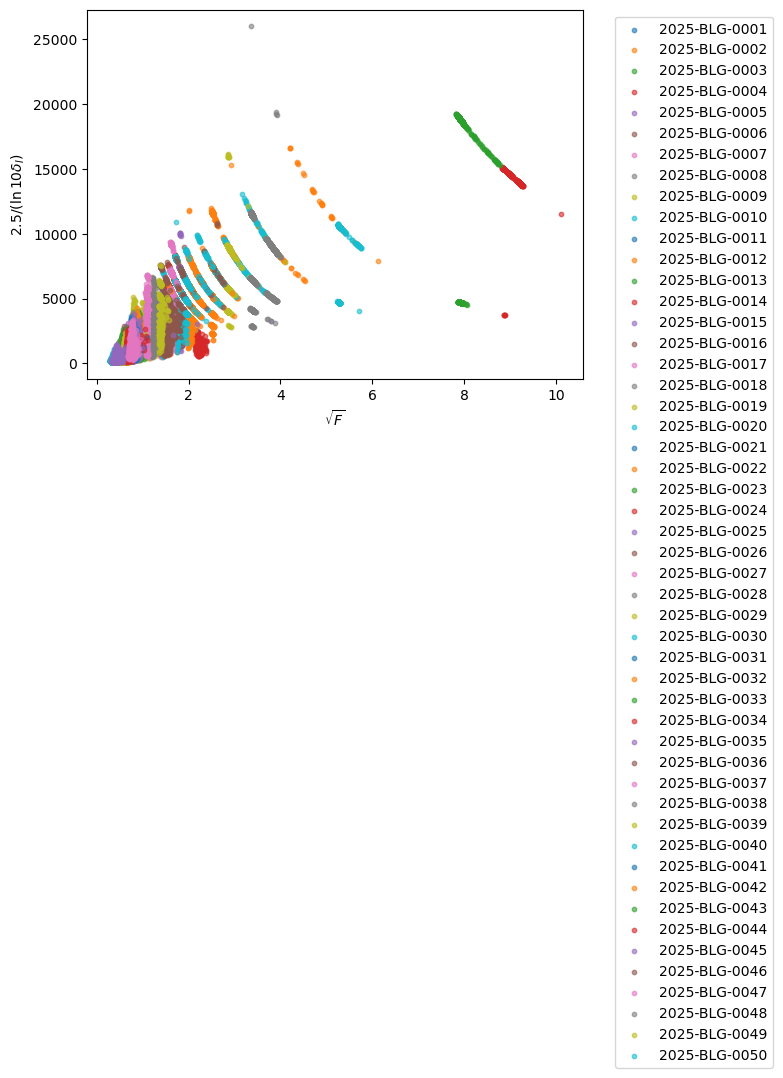

In [9]:
# plotting the SNR proxies

plt.figure()

X = []  # Use lists instead, much easier
Y = []

for event_id, data in OGLE_data.items():
    flux = mag_to_flux(data['I magnitude'].values, band="I", obs="OGLE")  # .values converts pandas Series to numpy array
    flux_err = flux * data['magnitude error'].values * np.log(10) / 2.5  # Convert mag error to flux error
    snr= flux / flux_err**2  # = F * 2.5 / (F * mag_err * ln(10)) = 2.5 / (mag_err * ln(10))
    #print(f"SNR ({event_id}): min={min(snr)}, max={max(snr)}, mean={np.mean(snr)}")

    y = 2.5 /(np.log(10.0) * data['magnitude error'].values)  # .values converts to numpy array
    x = np.sqrt(flux)

    plt.scatter(x, snr, label=event_id, alpha=0.6, s=10)  # Added alpha and smaller size for better visualization

    X.extend(x)  # Add all points to the list
    Y.extend(snr)

# Convert lists to numpy arrays for fitting
X = np.array(X)
Y = np.array(Y)

# Fit a line to all the data
def line(x, m, c):
    y = m*x + c
    return y

def chi2(args, model, x, y):
    residuals = y - model(x, *args)
    return np.sum(residuals**2)/x**2

def lnprob(args, model, x, y):
    return -0.5 * chi2(args, model, x, y)

# emcee
# from emcee import EnsembleSampler
# ndim = 2
# nwalkers = 50
# nsteps = 1000
# nburn = 500
# p0 = [1800, 0.0]
# p0_state = p0 + 1e-4 * np.random.randn(nwalkers, ndim)  # initial guess for m and c

# sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=(line, X, Y))
# sampler.run_mcmc(p0_state, nsteps)

# xx = np.linspace(0, np.max(X), 100)
# yy = sampler.flatchain[nburn*nwalkers:, 0].mean() * xx + sampler.flatchain[nburn*nwalkers:, 1].mean()

# plt.plot(xx, yy, color='black', linestyle='--', linewidth=2, label=f'Fit: y = {sampler.flatchain[:, 0].mean():.5f}x + {sampler.flatchain[:, 1].mean():.5f}')   

# # plot the last 50 samples
# for i in range(50):
#     m = sampler.flatchain[-i, 0]
#     c = sampler.flatchain[-i, 1]
#     print(f"Sample {i}: m={m}, c={c}")
#     plt.plot(xx, line(xx, m, c), color='gray', alpha=0.3)

plt.ylabel(r"$2.5 /(\ln{10}\delta_{I})$")
plt.xlabel(r"$\sqrt{F}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.tight_layout()
plt.show()

## Spitzer

In [128]:
data_dir = "data/Spitzer/"

Spitzer_data = {}
for f in os.listdir(data_dir):
    if f.endswith(".dat") or f.endswith(".out"):
        event_id = f.split('.')[0]
        data = pd.read_csv(os.path.join(data_dir, f), header=None, sep=' ')
        
        if f.endswith(".out"):
            data = data.rename(columns={4: 'HJD_', 5: 'L flux', 6: 'flux error', 0: 'other1', 1: 'other2', 2: 'other3', 3: 'other4'})
            data = data[['HJD_', 'L flux', 'flux error']]
        else:
            # drop columns with NaN values
            data = data.dropna(axis=1)
            # get remaining column indexes
            remaining_cols = data.columns
            data = data.rename(columns={remaining_cols[0]: 'HJD_', remaining_cols[1]: 'L magnitude', remaining_cols[2]: 'magnitude error'})

            if event_id == "OB161195":
                zp = 18
            elif event_id == "OB161093":
                zp = 18.8
                
            data["L flux"] = mag_to_flux(data['L magnitude'].values, band="L", obs="Spitzer", zp=zp)
            data["flux error"] = data["L flux"] * data['magnitude error'].values * np.log(10) / 2.5

        # Process the data as needed
        Spitzer_data[event_id] = data

In [156]:
print(Spitzer_data.keys())
Spitzer_data['OB161195'].head()
S = {
    'OB161195': 1.0,  # 0.65, 1.77
    'OB161093': 1.0,  # 0.9, 0.4
    'OB171038': 1.0
}

for event_id, data in Spitzer_data.items():
    err_rescaling = S.get(event_id, 1.0)
    data['flux error rescaled'] = data['flux error'] * err_rescaling


dict_keys(['OB171038', 'OB161195', 'OB161093'])


SNR (OB171038): min=275.08857494403844, max=472.5308110308972, mean=nan
SNR (OB161195): min=11.599745777330442, max=35.832878044822756, mean=19.58815839293461
SNR (OB161093): min=53.85596253760563, max=111.47188960555742, mean=75.68895753527079


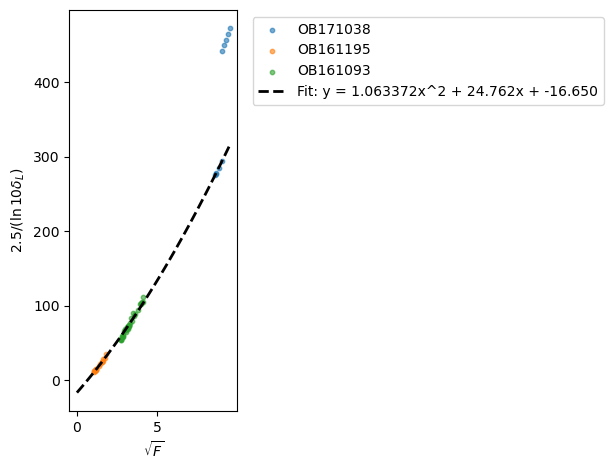

In [178]:
# plotting the SNR proxies

plt.figure()

X = []  # Use lists instead, much easier
Y = []

for event_id, data in Spitzer_data.items():
    flux = data['L flux'].values  # .values converts pandas Series to numpy array
    flux_err =data['flux error rescaled'].values
    snr= flux / flux_err  # = F * 2.5 / (F * mag_err * ln(10)) = 2.5 / (mag_err * ln(10))
    print(f"SNR ({event_id}): min={min(snr)}, max={max(snr)}, mean={np.mean(snr)}")

    y = snr.copy()  # .values converts to numpy array
    x = np.sqrt(flux)

    plt.scatter(x, y, label=event_id, alpha=0.6, s=10)  # Added alpha and smaller size for better visualization

    X.extend(x)  # Add all points to the list
    Y.extend(y)

# Convert lists to numpy arrays for fitting
X = np.array(X)
Y = np.array(Y)

# Fit a line to all the data

m = np.polyfit(X[(Y<400)], Y[(Y<400)], 2)

xx = np.linspace(0, np.max(X), 100)
yy = m[0] * xx**2 + m[1] * xx + m[2]

#plt.plot(X[~((Y<400)*(X>5))], Y[~((Y<400)*(X>5))], 'kx')

plt.plot(xx, yy, color='black', linestyle='--', linewidth=2, label=f'Fit: y = {m[0]:.6f}x^2 + {m[1]:.3f}x + {m[2]:.3f}')

plt.ylabel(r"$2.5 /(\ln{10}\delta_{L})$")
plt.xlabel(r"$\sqrt{F}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.tight_layout()
#plt.xlim(8, 10)
plt.show()